In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm

In [2]:
from NeuralNetwork.dense import Dense
from NeuralNetwork.activations import Sigmoid,Softmax,ReLU
from NeuralNetwork.losses import categorical_crossentropy, categorical_crossentropy_derive
from NeuralNetwork.network import predict

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
X = mnist.data/255.0
labels = np.array( mnist.target).astype(int)
y = np.squeeze(np.eye(10)[labels])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
X_val, y_val = X_train.iloc[:2000],y_train[:2000]

In [5]:
def train(NN, loss, loss_derive, X_train, y_train,X_val,y_val,epoch=20, alpha=0.05, verbose = True):
    X_train = np.reshape(X_train,X_train.shape +(1,))
    y_train = np.reshape(y_train,y_train.shape +(1,))
    X_val = np.reshape(X_val,X_val.shape +(1,))
    y_val = np.reshape(y_val,y_val.shape +(1,))
    error_TS = []
    acc_TS = []
    val_error_TS = []
    val_acc_TS = []
    for e in range(epoch):
        errors= 0
        acc =0
        val_error = 0
        val_acc = 0
        for x, y in zip(X_train, y_train):
            # forward
            out = predict(NN, x)
            if np.argmax(y)==np.argmax(out):
                acc+=1
            # error

            errors+= loss(y, out)

            # backward
            gradient = loss_derive(y, out)
            for layer in reversed(NN):
                gradient = layer.backward(gradient, alpha)

        for x, y in zip(X_val, y_val):
            output = predict(NN, x)
            if np.argmax(y)==np.argmax(output):
                val_acc+=1
            val_error += loss(y, output)
        
        errors/= len(X_train)
        acc /=len(X_train)
        val_error /= len(X_val)
        val_acc /=len(X_val)

        if verbose:
            print(f"{e + 1}/{epoch}, error={round(errors,4)}, accuracy={round(acc,4)}, val_error={round(val_error,4)}, val_accuracy={round(val_acc,4)}")
        error_TS.append(errors)
        acc_TS.append(acc)
        val_error_TS.append(val_error)
        val_acc_TS.append(val_acc)
    return [error_TS,acc_TS,val_error_TS,val_acc_TS]

In [6]:
def graph_train(train_error,train_acc,val_error,val_acc,index=False):
    add_index = ""
    if index:
        add_index+=index
    plt.plot(train_error)
    plt.plot(val_error)
    plt.xlabel("Epochs")
    plt.ylabel("Error")        
    plt.legend(['train error','validation error'])
    plt.savefig("./graph/Error{}.png".format(add_index))
    plt.clf()
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train accuracy','validation accuracy'])

    plt.savefig("./graph/Accuracy{}.png".format(add_index))

In [8]:
NN = [Dense(784,128),
      Sigmoid(),
      Dense(128,10),
      Softmax()]

In [9]:
train_error,train_acc,val_error,val_acc = train(NN,categorical_crossentropy,categorical_crossentropy_derive,X_train,y_train,X_val,y_val,alpha=0.06,epoch=20)

1/20, error=0.0462, accuracy=0.8798, val_error=0.04, val_accuracy=0.883
2/20, error=0.0213, accuracy=0.9385, val_error=0.0193, val_accuracy=0.9405
3/20, error=0.015, accuracy=0.9567, val_error=0.0127, val_accuracy=0.961
4/20, error=0.0114, accuracy=0.9655, val_error=0.0104, val_accuracy=0.968
5/20, error=0.0087, accuracy=0.9737, val_error=0.0083, val_accuracy=0.9715
6/20, error=0.007, accuracy=0.9787, val_error=0.0056, val_accuracy=0.9795
7/20, error=0.0053, accuracy=0.9842, val_error=0.0043, val_accuracy=0.986
8/20, error=0.0042, accuracy=0.988, val_error=0.0035, val_accuracy=0.9865
9/20, error=0.0033, accuracy=0.9909, val_error=0.0026, val_accuracy=0.991
10/20, error=0.0026, accuracy=0.9934, val_error=0.0025, val_accuracy=0.993


KeyboardInterrupt: 

In [10]:
graph_train(train_error,train_acc,val_error,val_acc,index="alternate")

NameError: name 'train_error' is not defined

In [11]:
def predict(NN, input):
    out = input
    for n in NN[:-1]:
        out = n.forward(out)
    return out

In [12]:
#make pairs
k=100

In [13]:
from sklearn.utils import shuffle
def get_top(X,labels,k=100):
    #dataset = np.column_stack((X,labels))
    X_sample, labels_sample = shuffle(X, labels, )

    topk = []
    for _class in range(10):
        class_index = np.where(labels_sample==_class)[0][:k]
        topk.append(np.column_stack((X_sample.iloc[class_index],labels_sample[class_index])))
    topk = np.vstack(topk)
    return topk

In [14]:
top100 = get_top(X,labels)
np.random.shuffle(top100)

In [15]:
pairs = []
pair_labels = []
for row1 in top100:
    for row2 in top100:
        pairs.append(np.hstack((row2[:-1],row1[:-1])))
        if row1[-1]==row2[-1]:
            pair_labels.append(1)
        else:
            pair_labels.append(0)

pairs = np.vstack(pairs)
pair_labels = np.array(pair_labels)

In [16]:
X_train,X_val,y_train,y_val = train_test_split(pairs,pair_labels,test_size=0.2,shuffle=True)

In [35]:
def predict_siamese(NN,X,threshold=0.5):
    X_sample = X.reshape(len(X), 2, 784)
    predictions = []
    first_images = []
    second_images = []
    
    for sample in X_sample:
        first_images.append(predict(NN,sample[0].reshape(784,1)))
        second_images.append(predict(NN,sample[1].reshape(784,1)))

    for first,second in zip(first_images,second_images):
        euclidean_dist =np.sqrt(np.sum(np.square(first - second)))
        if euclidean_dist<threshold:
            print(euclidean_dist)
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [18]:
def eval(predictions,true_val):
    acc = 0
    for pred,true in zip(predictions,true_val):
        if pred==true:
            acc+=1
    return acc/len(true_val)

In [19]:
topk = get_top(X,labels,k=10)
np.random.shuffle(topk)

In [30]:
def eval_siamese(X_sample,label_sample,k=5,threshold = 1.0):
    topk = get_top(X,labels,k)
    np.random.shuffle(topk)
    predictions = []
    for sample,label in tqdm.tqdm(zip(X_sample.to_numpy(),label_sample)):
        pairs = []
        pair_labels = []
        for row in topk:
            pairs.append(np.hstack((sample[:],row[:-1])))
            pair_labels.append(row[-1])
        pairs = np.vstack(pairs)
        pair_labels = np.array(pair_labels).astype(int)
        sample_predictions = predict_siamese(NN,pairs,threshold=threshold)
        predict = np.bincount(pair_labels[sample_predictions==1])
        if predict.size:
            predictions.append(predict.argmax())
        else:
            predictions.append(10)
    acc = eval(np.array(predictions),label_sample.argmax(axis=1))
    return {'k':k,'acc':acc}

In [31]:
outputs = []
for X_sample,y_label in tqdm.tqdm(zip([X_test,X_val,X_train],[y_test,y_val,y_train])):
    output = eval_siamese(X_sample,y_label,k=20)
    outputs.append(output)

0it [00:00, ?it/s]

In [28]:
X_val.shape

(200000, 1568)

In [52]:
eval_siamese(pd.DataFrame(X_test),y_test,k=8,threshold=26)

0it [00:00, ?it/s]

18.29821192304789
18.95487056079535
16.05020054968616
17.71581493115328
23.98654337878601
9.948687606157153
25.77943446141899
23.569405987591203
25.43510838289696
13.795342985717063
25.972769082331997
16.807698052930707
13.547090109764651
18.5179000347744
24.3104011130803
22.667850535846622
23.055715350592582
19.91125882646302
21.788556150626473
19.208068518035045
17.796973727751617
20.906170164426168
14.29505027504795
24.978677176196406
20.195652990795853
19.648492728882477
15.266104177179225
9.911290712770226
16.448479035902633
12.240580179208026
21.534934522821416
20.405139881641965
18.297538247815123
22.232366202830594
22.154468694715376
24.319473482053326
23.076728414937342
23.87573152189101
25.025839586054843
12.95268501799887
22.86008908842408
19.04543027508668
20.305923321232875
25.512026542634644
22.179246333120833
20.115073294945745
19.860973912182992
22.07977325078467
22.52617723553342
18.107174023214014
16.75005415490473
8.445182394777282
19.20246284840974
18.34067956318059

{'k': 8, 'acc': 0.9247857142857143}

In [40]:
# Multiclass values
plotsA = [{'dataset': 'test', 'acc': 0.9743571},#test,
{'dataset': 'validation', 'acc': 0.9837}#val
, {'dataset': 'training', 'acc': 0.978}]

In [83]:
plots = pd.DataFrame(outputs)

plotsA = pd.DataFrame(plotsA)

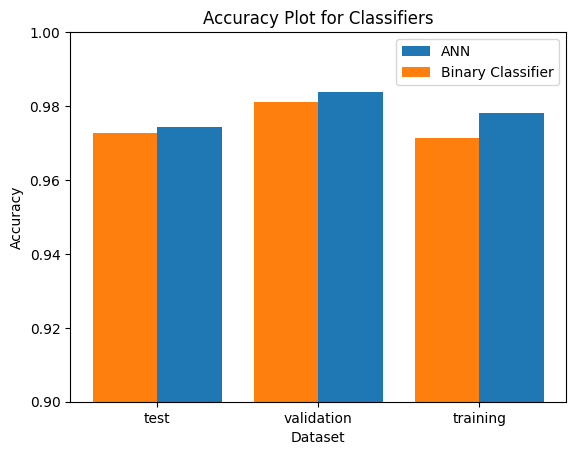

In [ ]:
X_axis =np.arange(len(plots))
plt.bar(X_axis+0.2,plotsA['acc'],0.4,label='ANN')
plt.bar(X_axis-0.2,plots['acc'],0.4,label='Binary Classifier')
plt.xticks(X_axis,plots['dataset'])
plt.title('Accuracy Plot for Classifiers')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0.9,1.0)
plt.legend()
plt.savefig('./graph/compare.png')

In [111]:
outputs = []
for k in tqdm.tqdm([1,2,4,8,16,32,64]):
    output = eval_siamese(X_test,y_test,k=k)
    outputs.append(output)

  0%|          | 0/7 [00:00<?, ?it/s]

In [112]:
plots = pd.DataFrame(outputs)

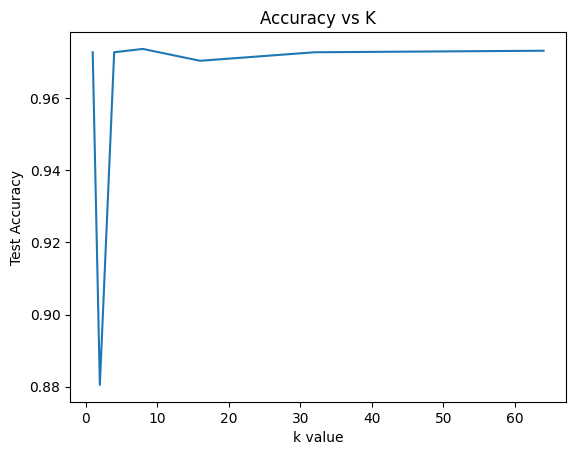

In [113]:
plt.plot(plots['k'],plots['acc'])
plt.title('Accuracy vs K')
plt.xlabel('k value')
plt.ylabel('Test Accuracy')
plt.savefig('./graph/acc_vs_k.png')